## BA 476 Project Group 9
### Game Recommendations

Data:


*   [Kaggle Link](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam)
*   [Merged Zip Data](https://drive.google.com/file/d/1wqaaLRKbC3wiUQ7Nq9wjVjxD9LIGv3rc/view?usp=drive_link)
*   [Downsampled Final Data CSV](https://drive.google.com/file/d/1dWDxnrCRq0L-XVi0Ake0JcI5u24HQbXI/view?usp=drive_link)



In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#google drive upload
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Engineering
- Merge the 3 tables ✅
- Find a representitive sample for this project ✅

In [ ]:
# '''
# Merging games, recommendations, and users dataframes based on common columns
# 1. games.csv - app_id (primary key)
# 2. recommendations.csv - app_id (foreign key), user_id (foreign key)
# 3. users.csv - user_id (primary key)
# '''

# #check null values specifically in the primary/foreign key columns for all 3 datasets
# print(games.isnull().sum())
# print(recommendations.isnull().sum())
# print(users.isnull().sum())

# # Great! We have no null values in our primary/foreign key columns so let's proceed with merging the data

# '''
# Disclaimer: This code block can not be run on Google Collab due to the large dataset (40+ Million rows)

# Solution: Ran this code locally (Dell XPS) on VS code and exported as a csv

# The rest of this notebook will use this new csv file called 'merged_games.csv'
# '''


# # merged_df = pd.merge(games, recommendations, on='app_id', how='inner')
# # merged_df = pd.merge(merged_df, users, on='user_id', how='inner')
# # merged_df.to_csv('merged_games.csv', index=False)

The merged data is very large therefore we will opt a stratified sampling strategy to reduce the runtime and work with a smaller dataset.  

### Stratified Sampling

#### Methodology:   

*   `game_sample`: We first randomly sample games that are above the 95th percentile in number of reviews  to get a diverse set of games.
*   `filtered_df`: We filter the dataset to include only the rows corresponding to the selected games.
*   `groupby('is_recommended')`: We stratify the sample by the `is_recommended` column, ensuring that we have both recommended and non-recommended reviews. We use the frac=0.5 argument to take 50% from each group.
*   `reset_index(drop=True)`: After grouping and applying the sampling, we reset the index to ensure a clean DataFrame.

In [ ]:
# # Sample a fraction of games
# game_sample = popular_games['app_id']

# # Now filter the DataFrame to only include the sampled games
# filtered_df = merged[merged['app_id'].isin(game_sample)]

# # Perform stratified sampling based on the 'is_recommended' column
# # This ensures we have equal representation of recommended and not recommended reviews
# sampled_df = filtered_df.groupby('is_recommended').apply(
#     lambda x: x.sample(frac=0.5, random_state=42)
# ).reset_index(drop=True)

# # Check the resulting sampled DataFrame
# display(sampled_df['is_recommended'].value_counts())
# display(sampled_df.head())


In [ ]:
# sampled_df_reduced = sampled_df.groupby('is_recommended').apply(
#     lambda x: x.sample(frac=0.0025, random_state=42)
# ).reset_index(drop=True)

# # Check the resulting sampled DataFrame and value counts
# display(sampled_df_reduced['is_recommended'].value_counts())
# display(sampled_df_reduced.head())

In [ ]:
# # Find the number of samples to draw from each class
# min_count = sampled_df_reduced['is_recommended'].value_counts().min()

# # Perform balanced sampling
# sampled_df_reduced = sampled_df_reduced.groupby('is_recommended').apply(
#     lambda x: x.sample(n=min_count, random_state=42)
# ).reset_index(drop=True)

# # Display the balanced sampled DataFrame
# display(sampled_df_reduced['is_recommended'].value_counts())
# display(sampled_df_reduced.head())
# sampled_df_reduced.to_csv('sampled_df_reduced.csv', index=False)

## Sampled Data Loading

In [ ]:
# sampled_df_reduced = pd.read_csv('sampled_df_reduced.csv')
sampled_df_reduced = pd.read_csv('/content/drive/MyDrive/sampled_df_reduced.csv')

In [ ]:
print(sampled_df_reduced['is_recommended'].value_counts())
sampled_df_reduced.info()

is_recommended
False    57679
True     57679
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115358 entries, 0 to 115357
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   app_id          115358 non-null  int64  
 1   title           115358 non-null  object 
 2   date_release    115358 non-null  object 
 3   win             115358 non-null  bool   
 4   mac             115358 non-null  bool   
 5   linux           115358 non-null  bool   
 6   rating          115358 non-null  object 
 7   positive_ratio  115358 non-null  int64  
 8   user_reviews    115358 non-null  int64  
 9   price_final     115358 non-null  float64
 10  price_original  115358 non-null  float64
 11  discount        115358 non-null  float64
 12  steam_deck      115358 non-null  bool   
 13  helpful         115358 non-null  int64  
 14  funny           115358 non-null  int64  
 15  date            115358 non-null

In [ ]:
sampled_df_reduced.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,...,steam_deck,helpful,funny,date,is_recommended,hours,user_id,review_id,products,reviews
0,387990,Scrap Mechanic,2016-01-19,True,False,False,Very Positive,93,90219,20.0,...,True,0,0,2017-03-28,False,11.2,9662245,7636434,0,1
1,504370,Battlerite,2017-11-08,True,False,False,Very Positive,84,58661,0.0,...,True,0,0,2021-04-24,False,2.6,2820494,33234095,8,2
2,333930,Dirty Bomb®,2015-06-01,True,False,False,Very Positive,81,57915,0.0,...,True,0,0,2015-07-02,False,89.0,1859002,27930415,930,4
3,252490,Rust,2018-02-08,True,True,False,Very Positive,87,786668,40.0,...,True,0,0,2021-09-17,False,181.4,10895362,3393198,13,1
4,322330,Don't Starve Together,2016-04-21,True,True,True,Overwhelmingly Positive,95,280962,15.0,...,True,0,0,2020-05-17,False,320.9,10270107,33594603,24,6


## Feature Engineering


*   Create dummy variables for `rating`

In [ ]:
print(f"We have {len(sampled_df_reduced['rating'].unique())} unique ratings")
print(sampled_df_reduced['rating'].unique())

We have 6 unique ratings
['Very Positive' 'Overwhelmingly Positive' 'Mixed' 'Mostly Positive'
 'Overwhelmingly Negative' 'Mostly Negative']


In [ ]:
# create dummies for 'rating'
dummy_df = pd.get_dummies(sampled_df_reduced["rating"], prefix="rating")

# remove the original 'rating' column
sampled_df_reduced = sampled_df_reduced.drop("rating", axis=1)

# join the dummy variables back to the original DataFrame
sampled_df_reduced = pd.concat([sampled_df_reduced, dummy_df], axis=1)

In [ ]:
# Convert 'date_release' and 'date' to datetime format
sampled_df_reduced['date_release'] = pd.to_datetime(sampled_df_reduced['date_release'])
sampled_df_reduced['date'] = pd.to_datetime(sampled_df_reduced['date'])

# Create a new column with the difference in dates
sampled_df_reduced['date_diff'] = sampled_df_reduced['date'] - sampled_df_reduced['date_release']

sampled_df_reduced['date_diff_days'] = sampled_df_reduced['date_diff'].dt.days # this column will represent the number of days the review was made after the game was released

# remove the original 'date_diff', 'date' and 'date_release' column
sampled_df_reduced = sampled_df_reduced.drop(columns=['date', 'date_release', 'date_diff'], axis=1)

sampled_df_reduced.head()

,app_id,title,win,mac,linux,positive_ratio,user_reviews,price_final,price_original,discount,...,review_id,products,reviews,rating_Mixed,rating_Mostly Negative,rating_Mostly Positive,rating_Overwhelmingly Negative,rating_Overwhelmingly Positive,rating_Very Positive,date_diff_days
0,387990,Scrap Mechanic,True,False,False,93,90219,20.0,0.0,0.0,...,7636434,0,1,False,False,False,False,False,True,434
1,504370,Battlerite,True,False,False,84,58661,0.0,0.0,0.0,...,33234095,8,2,False,False,False,False,False,True,1263
2,333930,Dirty Bomb®,True,False,False,81,57915,0.0,0.0,0.0,...,27930415,930,4,False,False,False,False,False,True,31
3,252490,Rust,True,True,False,87,786668,40.0,0.0,0.0,...,3393198,13,1,False,False,False,False,False,True,1317
4,322330,Don't Starve Together,True,True,True,95,280962,15.0,0.0,0.0,...,33594603,24,6,False,False,False,False,True,False,1487


In [ ]:
sampled_df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115358 entries, 0 to 115357
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   app_id                          115358 non-null  int64  
 1   title                           115358 non-null  object 
 2   win                             115358 non-null  bool   
 3   mac                             115358 non-null  bool   
 4   linux                           115358 non-null  bool   
 5   positive_ratio                  115358 non-null  int64  
 6   user_reviews                    115358 non-null  int64  
 7   price_final                     115358 non-null  float64
 8   price_original                  115358 non-null  float64
 9   discount                        115358 non-null  float64
 10  steam_deck                      115358 non-null  bool   
 11  helpful                         115358 non-null  int64  
 12  funny           

### Descriptive Analysis

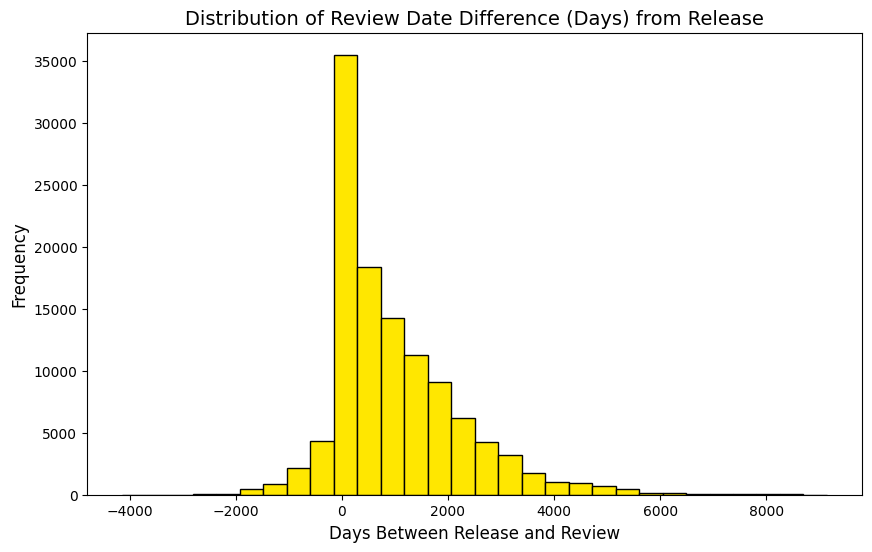

In [ ]:
# Create a histogram of the 'date_diff_days' column
plt.figure(figsize=(10, 6))
plt.hist(sampled_df_reduced['date_diff_days'], bins=30, edgecolor='black', color='#ffe700')

# Add labels and title
plt.title('Distribution of Review Date Difference (Days) from Release', fontsize=14)
plt.xlabel('Days Between Release and Review', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.grid(False)
plt.show()

In [ ]:
sampled_df_reduced["date_diff_days"].describe()

,date_diff_days
count,115358.000000
mean,967.954221
std,1238.190429
min,-4139.000000
25%,56.000000
50%,624.000000
75%,1584.000000
max,9146.000000


1. Shape of the Distribution:
  * The distribution appears to be skewed to the right (positively skewed), with a large peak near 0, which represents reviews made around the release date of the game.
  * The bulk of the reviews are clustered near 0, meaning most reviews were made shortly after the release. However, there is a long tail extending to the right, indicating that some reviews are made much later after the release (several years later in some cases).
  * There is also a smaller left tail, indicating a smaller number of reviews that were made before the release.

2. Central Tendency
  * Mean: The average number of days is positive (967.95 days), which means that, on average, reviews tend to come after the release.
  * Median: The median (624 days) is lower than the mean, which is another indicator of a right-skewed distribution (because the tail is pulling the mean to the right).
  * Peak Near Zero: The mode or most frequent number of days appears to be around 0, which indicates that a lot of reviews are written very close to the game's release.

Takeaways:
* The majority of reviews are made soon after the release of the game, with a peak near 0 days.
* The distribution is right-skewed, with a long tail to the right, indicating that some reviews are written much later after the release.
* A small number of reviews are written before the release date, which could be related to leaks or promotional reviews.
* The mean is greater than the median, suggesting a positive skew, and the standard deviation is large, indicating a wide spread in the data.

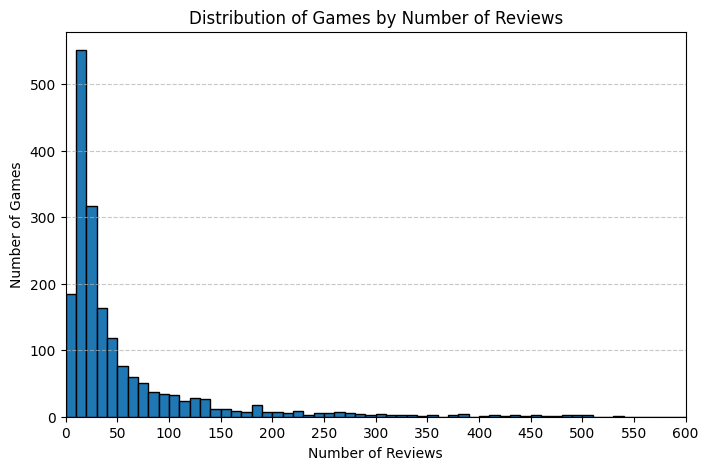

In [89]:
# Count number of reviews per unique game
game_review_counts = sampled_df_reduced['app_id'].value_counts()

# Create histogram bins
bins = np.arange(0, 610, 10)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(game_review_counts, bins=bins, edgecolor='black')
plt.title('Distribution of Games by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Games')
plt.xlim(0, 600)
plt.xticks(ticks=np.arange(0, 610, 50))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Model Preparation

In [ ]:
# Look through all potential predictors
potential_predictors = [col for col in sampled_df_reduced.columns if col not in ['app_id', 'user_id', 'review_id', 'title', 'price_final', 'is_recommended']]

X = sampled_df_reduced[potential_predictors]
y = sampled_df_reduced['is_recommended']

In [ ]:
feature_amount = len(potential_predictors)
print(feature_amount)

20


In [ ]:
print(f"The predictors: \n{X.columns}")

The predictors: 
Index(['win', 'mac', 'linux', 'positive_ratio', 'user_reviews',
       'price_original', 'discount', 'steam_deck', 'helpful', 'funny', 'hours',
       'products', 'reviews', 'rating_Mixed', 'rating_Mostly Negative',
       'rating_Mostly Positive', 'rating_Overwhelmingly Negative',
       'rating_Overwhelmingly Positive', 'rating_Very Positive',
       'date_diff_days'],
      dtype='object')


Feature Selection Attempt (not used!)

In [ ]:
# # Feature selection

# # # Manual
# # numerical_predictors = ['products', 'reviews', 'user_reviews', 'hours', 'price_final', 'positive_ratio'] # not sure about rating/positive_ratio since it's a static variable for each game
# # categorical_predictors = ['steam_deck']
# # X = sampled_df[numerical_predictors + categorical_predictors
# # y = sampled_df['is_recommended']

# # For trees
# from sklearn.feature_selection import SelectKBest, chi2

# best_features = SelectKBest(score_func=chi2, k=15)
# fit = best_features.fit(X.drop('date_diff_days', axis=1),y)
# print(fit.get_feature_names_out()) # prints best features
# print(fit.scores_)
# # Set X to the best features
# select_k_predictors = fit.get_feature_names_out()
# X = sampled_df_reduced[select_k_predictors]


In [ ]:
# majority = max(len(sampled_df_reduced[sampled_df_reduced.is_recommended == True]), len(sampled_df_reduced[sampled_df_reduced.is_recommended == False]))
# baseline = majority / len(sampled_df_reduced)
# print(f'Sample baseline accuracy: {baseline}')
# print('Original data baseline accuracy: 0.86')

## Experimenting with Predictive Models

Dataframe: `sampled_df_reduced`  
Predictors: `X`   
Outcome Variable: `y`

### Linear Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1. choose model class
from sklearn.linear_model import LinearRegression
# 2. instantiate model
lr = LinearRegression()
# 3. fit model to data
lr.fit(X_train, y_train)
# predict, evaluate
yhat_test_lr = lr.predict(X_test)
round(mean_squared_error(y_test, yhat_test_lr),4)

0.2076

Stepwise Feature Selection

In [ ]:
# Initialize the linear regression model
base_lr = LinearRegression()

# Store the cross-validation scores for each number of features
cv_scores = []

# Iterate over the number of features
for i in range(1, len(X.columns)):
    # Initialize SequentialFeatureSelector with the desired number of features
    sfs = SequentialFeatureSelector(estimator=base_lr, n_features_to_select=i, direction='forward')

    # Fit the selector to the training data
    sfs.fit(X_train, y_train)

    # Get the selected features
    selected_features = X_train.columns[sfs.get_support()]

    # Use cross-validation to evaluate the model with the selected features
    X_train_selected = X_train[selected_features]
    score = np.mean(cross_val_score(base_lr, X_train_selected, y_train, cv=5, scoring='r2'))

    # Store the score for this number of features
    cv_scores.append(score)

# Find the number of features that gave the best cross-validation score
optimal_num_features = np.argmax(cv_scores) + 1  # Adding 1 because the index starts from 0
optimal_score = cv_scores[optimal_num_features - 1]

print(f"Optimal number of features: {optimal_num_features}")
print(f"Cross-validation R² score for the optimal number of features: {optimal_score}")

Optimal number of features: 16
Cross-validation R² score for the optimal number of features: 0.16830012031375705


In [ ]:
# Get the selected features for the optimal number (16 features)
sfs = SequentialFeatureSelector(estimator=base_lr, n_features_to_select=optimal_num_features, direction='forward')
sfs.fit(X_train, y_train)

# Get the selected features (names of the features selected by the SFS)
selected_features = X_train.columns[sfs.get_support()]

# Output the selected predictors
print(f"Selected features: {selected_features.tolist()}")

# Create a new DataFrame with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the final LinearRegression model using the selected features
final_model = LinearRegression()
final_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test_selected)

# Evaluate the model
test_r2_score = r2_score(y_test, y_pred)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE) on the test set: {mse}")
print(f"R² score on the test set: {test_r2_score}")


Selected features: ['win', 'positive_ratio', 'user_reviews', 'price_original', 'helpful', 'funny', 'hours', 'products', 'reviews', 'rating_Mixed', 'rating_Mostly Negative', 'rating_Mostly Positive', 'rating_Overwhelmingly Negative', 'rating_Overwhelmingly Positive', 'rating_Very Positive', 'date_diff_days']
Mean Squared Error (MSE) on the test set: 0.2076109349430819
R² score on the test set: 0.16952021516746119


### Ridge Regression

default model

In [ ]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(X_train) #applies mean and std of training set
x_test_std = scaler.transform(X_test) #we use only transform to prevent data leakage
x_test_std.mean(0)

# fit a ridge model
ridge = Ridge(alpha=0.1)
ridge.fit(x_train_std, y_train)
print(ridge.coef_)

# predict and evaluate on test set
yhat_test_rg = ridge.predict(x_test_std)
round(mean_squared_error(y_test,yhat_test_rg),4)

[-3.17800406e-03 -1.98571451e-04  9.29174016e-04  2.21699130e-01
 -2.12085755e-02  1.31270036e-02  1.10676795e-04  5.37525926e-04
 -1.23725184e-02  3.32169100e-03  3.63033794e-02 -1.52407539e-02
 -8.18388077e-03  3.02496351e-02  4.12093995e-02 -2.15764506e-02
  2.31074206e-02  2.37376111e-02 -3.17828382e-02  5.63390959e-03]


0.2076

Grid Search Cross Validation

In [ ]:
# Apply scaling to the training and test sets
scaler = StandardScaler()
x_train_std = scaler.fit_transform(X_train)  # Applies mean and std of training set
x_test_std = scaler.transform(X_test)  # Use only transform to prevent data leakage

# Initialize the Ridge model
ridge = Ridge()

# Set up the range of alpha values to search over
alpha_values = np.logspace(-6, 6, 13)  # Alpha values from 1e-6 to 1e6 (log scale)

# Set up the hyperparameter grid for GridSearchCV
param_grid = {'alpha': alpha_values}

# Set up GridSearchCV to search for the best alpha using 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(x_train_std, y_train)

# Print the best alpha found by GridSearchCV
print(f"Optimal alpha: {grid_search.best_params_['alpha']}")

# Get the best Ridge model from the grid search
best_ridge = grid_search.best_estimator_

# Fit the best model on the entire training set
best_ridge.fit(x_train_std, y_train)

# Print the coefficients of the best model
print(f"Best Ridge Coefficients: {best_ridge.coef_}")

# Print the selected predictors (features) based on the best alpha value
selected_predictors = X_train.columns
print(f"Selected predictors: {selected_predictors.tolist()}")

# Predict and evaluate on the test set
yhat_test_rg = best_ridge.predict(x_test_std)

# Calculate and print the Mean Squared Error on the test set
test_mse = mean_squared_error(y_test, yhat_test_rg)
print(f"Test set MSE: {round(test_mse, 4)}")

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Optimal alpha: 10.0
Best Ridge Coefficients: [-3.17840137e-03 -1.92854182e-04  9.34771185e-04  2.21441721e-01
 -2.12109998e-02  1.31261198e-02  1.16000699e-04  5.36433000e-04
 -1.23711830e-02  3.32072619e-03  3.62934685e-02 -1.52383038e-02
 -8.18357690e-03  3.01037490e-02  4.11111691e-02 -2.16195429e-02
  2.30605562e-02  2.38438875e-02 -3.17232069e-02  5.64225447e-03]
Selected predictors: ['win', 'mac', 'linux', 'positive_ratio', 'user_reviews', 'price_original', 'discount', 'steam_deck', 'helpful', 'funny', 'hours', 'products', 'reviews', 'rating_Mixed', 'rating_Mostly Negative', 'rating_Mostly Positive', 'rating_Overwhelmingly Negative', 'rating_Overwhelmingly Positive', 'rating_Very Positive', 'date_diff_days']
Test set MSE: 0.2076


### Lasso Regression

default model

In [ ]:
lasso_pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.01))
lasso_pipe.fit(X_train, y_train)
yhat_test_ls = lasso_pipe.predict(X_test)

print(lasso_pipe['lasso'].coef_)
print(X_train.columns[lasso_pipe['lasso'].coef_ != 0])
round(mean_squared_error(y_test, yhat_test_ls), 4)

[-0.          0.          0.          0.14848277 -0.00861662  0.00145954
  0.         -0.         -0.00160815 -0.          0.01976159 -0.00764563
 -0.00042707 -0.          0.00621995 -0.01589669  0.00093989  0.05901937
 -0.          0.00018284]
Index(['positive_ratio', 'user_reviews', 'price_original', 'helpful', 'hours',
       'products', 'reviews', 'rating_Mostly Negative',
       'rating_Mostly Positive', 'rating_Overwhelmingly Negative',
       'rating_Overwhelmingly Positive', 'date_diff_days'],
      dtype='object')


0.2097

Grid Search Cross Validation

In [ ]:
# Apply scaling to the training and test sets
scaler = StandardScaler()
x_train_std = scaler.fit_transform(X_train)  # Applies mean and std of training set
x_test_std = scaler.transform(X_test)  # Use only transform to prevent data leakage

# Initialize the Lasso model
lasso = Lasso()

# Set up the range of alpha values to search over for Lasso (log scale for alpha)
alpha_values = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10])

# Set up the hyperparameter grid for GridSearchCV
param_grid = {'alpha': alpha_values}

# Set up GridSearchCV to search for the best alpha using 5-fold cross-validation
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the training data
grid_search_lasso.fit(x_train_std, y_train)

# Print the best alpha found by GridSearchCV
print(f"Optimal alpha for Lasso: {grid_search_lasso.best_params_['alpha']}")

# Get the best Lasso model from the grid search
best_lasso = grid_search_lasso.best_estimator_

# Fit the best model on the entire training set
best_lasso.fit(x_train_std, y_train)

# Print the coefficients of the best model
print(f"Best Lasso Coefficients: {best_lasso.coef_}")

# Print the selected predictors (features) with non-zero coefficients
selected_predictors = X_train.columns[best_lasso.coef_ != 0]  # Features with non-zero coefficients
print(f"Selected predictors for Lasso regression: {selected_predictors.tolist()}")

# Predict and evaluate on the test set
yhat_test_lasso = best_lasso.predict(x_test_std)

# Calculate and print the Mean Squared Error on the test set
test_mse_lasso = mean_squared_error(y_test, yhat_test_lasso)
print(f"Test set MSE for Lasso: {round(test_mse_lasso, 4)}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimal alpha for Lasso: 0.001
Best Lasso Coefficients: [-0.00219299  0.          0.00041926  0.20608871 -0.02003614  0.01219406
  0.          0.         -0.01045161  0.00130952  0.03447246 -0.01444883
 -0.0074044   0.03791501  0.03954131 -0.00429597  0.02125228  0.05156284
 -0.          0.00525323]
Selected predictors for Lasso regression: ['win', 'linux', 'positive_ratio', 'user_reviews', 'price_original', 'helpful', 'funny', 'hours', 'products', 'reviews', 'rating_Mixed', 'rating_Mostly Negative', 'rating_Mostly Positive', 'rating_Overwhelmingly Negative', 'rating_Overwhelmingly Positive', 'date_diff_days']
Test set MSE for Lasso: 0.2077


### Logistic Regression

default model

In [ ]:
# Apply scaling to the training and test sets (important for logistic regression)
scaler = StandardScaler()
x_train_std = scaler.fit_transform(X_train)  # Applies mean and std of training set
x_test_std = scaler.transform(X_test)  # Use only transform to prevent data leakage

# Initialize the Logistic Regression model (default settings)
log_reg = LogisticRegression()

# Fit the default logistic regression model
log_reg.fit(x_train_std, y_train)

# Predict and evaluate on the test set
yhat_test_logreg = log_reg.predict(x_test_std)
test_acc_logreg = accuracy_score(y_test, yhat_test_logreg)

print(f"Test set accuracy for default Logistic Regression: {round(test_acc_logreg, 4)}")

Test set accuracy for default Logistic Regression: 0.6759


Grid Search Cross Validation

In [ ]:
# Set up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': np.logspace(-6, 6, 13),  # Regularization strength (inverse of alpha)
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],  # Different solvers
}

# Set up GridSearchCV to search for the best hyperparameters using 5-fold cross-validation
grid_search_logreg = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the training data
grid_search_logreg.fit(x_train_std, y_train)

# Print the best hyperparameters found by GridSearchCV
print(f"Best parameters from GridSearchCV: {grid_search_logreg.best_params_}")

# Get the best Logistic Regression model from the grid search
best_logreg = grid_search_logreg.best_estimator_

# Predict and evaluate on the test set with the best model
yhat_test_best_logreg = best_logreg.predict(x_test_std)
test_acc_best_logreg = accuracy_score(y_test, yhat_test_best_logreg)

print(f"Test set accuracy for tuned Logistic Regression: {round(test_acc_best_logreg, 4)}")

# Print the coefficients of the best model.
print(f"Best Logistic Regression Coefficients: {best_logreg.coef_}")

Fitting 5 folds for each of 39 candidates, totalling 195 fits
Best parameters from GridSearchCV: {'C': np.float64(0.001), 'solver': 'lbfgs'}
Test set accuracy for tuned Logistic Regression: 0.6765
Best Logistic Regression Coefficients: [[-0.02561755  0.00774077  0.00837818  0.78286596 -0.09109417  0.06597759
   0.00590149  0.00206126 -0.17928952  0.04232544  0.15542475 -0.06583135
  -0.05730827 -0.0226049  -0.01121247 -0.10215642 -0.01122286  0.2143016
  -0.0796795   0.03640604]]


### Decision Tree Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'criterion': ['gini'],
    'min_samples_split': [500],
    'min_samples_leaf': [45],
    'min_impurity_decrease': [0.000001]
}
model = GridSearchCV(DecisionTreeClassifier(), params)
model.fit(X_train, y_train)
print(f'Best params: {model.best_params_}')

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
report = classification_report(y_test, y_pred)
print(f'Classes: \n{report}')
confusion = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{confusion}')

Best params: {'criterion': 'gini', 'min_impurity_decrease': 1e-06, 'min_samples_leaf': 45, 'min_samples_split': 500}
Accuracy: 0.7393810679611651
Classes: 
              precision    recall  f1-score   support

       False       0.75      0.73      0.74     11612
        True       0.73      0.75      0.74     11460

    accuracy                           0.74     23072
   macro avg       0.74      0.74      0.74     23072
weighted avg       0.74      0.74      0.74     23072

Confusion Matrix: 
[[8479 3133]
 [2880 8580]]


Decision Tree Results with all predictors


```
Accuracy: 0.665698682
Classes:
              precision    recall  f1-score   support

       False       0.67      0.66      0.67     11612
        True       0.66      0.67      0.67     11460

    accuracy                           0.67     23072
   macro avg       0.67      0.67      0.67     23072
weighted avg       0.67      0.67      0.67     23072

Confusion Matrix:
[[7700 3912]
 [3801 7659]]
```



Decision Tree, all predictors, Grid Search CV


```
Best params: {'criterion': 'gini', 'min_impurity_decrease': 1e-06, 'min_samples_leaf': 45, 'min_samples_split': 500}
Accuracy: 0.7403779472954231
Classes:
              precision    recall  f1-score   support

       False       0.75      0.74      0.74     11612
        True       0.74      0.75      0.74     11460

    accuracy                           0.74     23072
   macro avg       0.74      0.74      0.74     23072
weighted avg       0.74      0.74      0.74     23072

Confusion Matrix:
[[8543 3069]
 [2921 8539]]
```



The Decision Tree test MSE got worse with less predictors.

### Random Forest

default model

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=1, max_features='sqrt')
rf.fit(X_train, y_train)
yhat_rf = rf.predict(X_test)
mean_squared_error(y_test, yhat_rf)

0.31839459084604715

Grid Search Cross Validation

In [69]:
# Apply scaling to the training and test sets
scaler = StandardScaler()
x_train_std = scaler.fit_transform(X_train)  # Applies mean and std of training set
x_test_std = scaler.transform(X_test)  # Use only transform to prevent data leakage

# Initialize the Random Forest model
rf = RandomForestClassifier()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'bootstrap': [True],  # Whether bootstrap samples are used when building trees
    'random_state': [42]  # Random seed for reproducibility
}

# Set up GridSearchCV to search for the best hyperparameters using 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search_rf.fit(x_train_std, y_train)

# Print the best hyperparameters found by GridSearchCV
print(f"Best hyperparameters from GridSearchCV: {grid_search_rf.best_params_}")

# Get the best Random Forest model from the grid search
best_rf = grid_search_rf.best_estimator_

# Predict and evaluate on the test set with the best model
yhat_test_rf = best_rf.predict(x_test_std)

# Calculate and print the accuracy on the test set
test_accuracy_rf = accuracy_score(y_test, yhat_test_rf)
print(f"Test set accuracy for best Random Forest: {round(test_accuracy_rf, 4)}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best hyperparameters from GridSearchCV: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50, 'random_state': 42}
Test set accuracy for best Random Forest: 0.7541


In [70]:
# Apply scaling to the training and test sets
scaler = StandardScaler()
x_train_std = scaler.fit_transform(X_train)  # Applies mean and std of training set
x_test_std = scaler.transform(X_test)  # Use only transform to prevent data leakage

# Initialize the Random Forest model
rf = RandomForestClassifier()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100],  # Number of trees in the forest
    'max_depth': [None],  # Maximum depth of the tree
    'min_samples_split': [100],  # Minimum samples required to split an internal node
    'min_samples_leaf': [40],  # Minimum samples required to be at a leaf node
    'bootstrap': [True],  # Whether bootstrap samples are used when building trees
    'random_state': [42]  # Random seed for reproducibility
}

# Set up GridSearchCV to search for the best hyperparameters using 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search_rf.fit(x_train_std, y_train)

# Print the best hyperparameters found by GridSearchCV
print(f"Best hyperparameters from GridSearchCV: {grid_search_rf.best_params_}")

# Get the best Random Forest model from the grid search
best_rf = grid_search_rf.best_estimator_

# Predict and evaluate on the test set with the best model
yhat_test_rf = best_rf.predict(x_test_std)

# Calculate and print the accuracy on the test set
test_accuracy_rf = accuracy_score(y_test, yhat_test_rf)
print(f"Test set accuracy for best Random Forest: {round(test_accuracy_rf, 4)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters from GridSearchCV: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 40, 'min_samples_split': 100, 'n_estimators': 100, 'random_state': 42}
Test set accuracy for best Random Forest: 0.751


Random Forest's performance did not improve with feature selection.

### Gradient Boosting Classifier

In [ ]:
# Grid Search for optimal hyperparameters
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
gb_model = GradientBoostingClassifier(random_state=45)

# Smart, narrowed grid
param_grid = {
    'n_estimators': [250],              # Tried 50, 100, 200, 300
    'learning_rate': [0.3],            # Most useful values - tried range of [0.01, 3]
    'max_depth': [3],                     # Typical tree depths - tried [None, 3, 5]
}

# Grid search setup
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {accuracy}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
confusion = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{confusion}')

Best Hyperparameters:
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 250}
Accuracy score: 0.7506501386962552

Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.73      0.75     11612
        True       0.74      0.77      0.75     11460

    accuracy                           0.75     23072
   macro avg       0.75      0.75      0.75     23072
weighted avg       0.75      0.75      0.75     23072

Confusion Matrix: 
[[8466 3146]
 [2607 8853]]


Gradient Boosting with all 20 predictors:

```
Best Hyperparameters:
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 250}
Accuracy score: 0.750996879334258

Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.73      0.75     11612
        True       0.74      0.77      0.75     11460

    accuracy                           0.75     23072
   macro avg       0.75      0.75      0.75     23072
weighted avg       0.75      0.75      0.75     23072

Confusion Matrix:
[[8511 3101]
 [2644 8816]]
```

Gradient Boosting's performance did not improve with feature selection.

###ADA Boost###

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the range of hyperparameters we want to try for n_estimators and learning_rate
param_grid = {
    'n_estimators': [100,200,300],
    'learning_rate': [1.5, 2, 2.5]
}

In [ ]:
# Set up a grid search with 3-fold CV to find the best combination of hyperparameters
grid_search = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [1.5, 2, 2.5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
# extract the best model found & print out its best hyperparameters
best_ada = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 1.5, 'n_estimators': 300}


In [ ]:
# Use the tuned AdaBoost model to make predictions on the test set
y_pred = best_ada.predict(X_test)

In [ ]:
# Calculate and print the overall accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate and display a detailed classification report (precision, recall, f1-score)
report = classification_report(y_test, y_pred)
print(f'Classes: \n{report}')

# Compute and print the confusion matrix to see true vs. predicted class counts
confusion = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{confusion}')

Accuracy: 0.7417215672676838
Classes: 
              precision    recall  f1-score   support

       False       0.76      0.71      0.74     11612
        True       0.73      0.77      0.75     11460

    accuracy                           0.74     23072
   macro avg       0.74      0.74      0.74     23072
weighted avg       0.74      0.74      0.74     23072

Confusion Matrix: 
[[8295 3317]
 [2642 8818]]


### Best Model Evaluation on Out-of-Bag Steam Data

In [80]:
# Get out of bag sample to test robustness of model in predicting recommendations
new_entries_balanced = pd.read_csv('/content/drive/MyDrive//new_entries_balanced.csv')

# create dummies for 'rating'
dummy_df = pd.get_dummies(new_entries_balanced["rating"], prefix="rating")

# remove the original 'rating' column
new_entries_balanced = new_entries_balanced.drop("rating", axis=1)

# join the dummy variables back to the original DataFrame
new_entries_balanced = pd.concat([new_entries_balanced, dummy_df], axis=1)

# Convert 'date_release' and 'date' to datetime format
new_entries_balanced['date_release'] = pd.to_datetime(new_entries_balanced['date_release'])
new_entries_balanced['date'] = pd.to_datetime(new_entries_balanced['date'])

# Create a new column with the difference in dates
new_entries_balanced['date_diff'] = new_entries_balanced['date'] - new_entries_balanced['date_release']

new_entries_balanced['date_diff_days'] = new_entries_balanced['date_diff'].dt.days # this column will represent the number of days the review was made after the game was released

# remove the original 'date_diff', 'date' and 'date_release' column
new_entries_balanced = new_entries_balanced.drop(columns=['date', 'date_release', 'date_diff'], axis=1)

new_entries_balanced.head()

potential_predictors = [col for col in new_entries_balanced.columns if col not in ['app_id', 'user_id', 'review_id', 'title', 'price_final', 'is_recommended']]

X_new = new_entries_balanced[potential_predictors]
y_new = new_entries_balanced['is_recommended']

In [83]:
params = {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50, 'random_state': 42}
best_rf = RandomForestClassifier(**params)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [84]:
# Predict and evaluate on the new set with the best model
yhat_rf = best_rf.predict(X_new)

# Calculate and print the accuracy on the test set
accuracy_rf = accuracy_score(y_new, yhat_rf)
print(f"Test set accuracy for best Random Forest on out of sample balanced data: {round(accuracy_rf, 4)}")

Test set accuracy for best Random Forest on out of sample balanced data: 0.8018


In [87]:
param_gb = {
    'n_estimators': 250,
    'learning_rate': 0.30,
    'max_depth': 3,
}

best_gb = GradientBoostingClassifier(**param_gb)
best_gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=250)

In [88]:
# Predict and evaluate on the new set with the best model
yhat_gb = best_gb.predict(X_new)

# Calculate and print the accuracy on the test set
accuracy_gb = accuracy_score(y_new, yhat_gb)
print(f"Test set accuracy for best Random Forest on out of sample balanced data: {round(accuracy_gb, 4)}")

Test set accuracy for best Random Forest on out of sample balanced data: 0.7562


### Ranked Feature Importance

Fitting 5 folds for each of 9 candidates, totalling 45 fits


<ipython-input-45-c0471ed7dca0>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


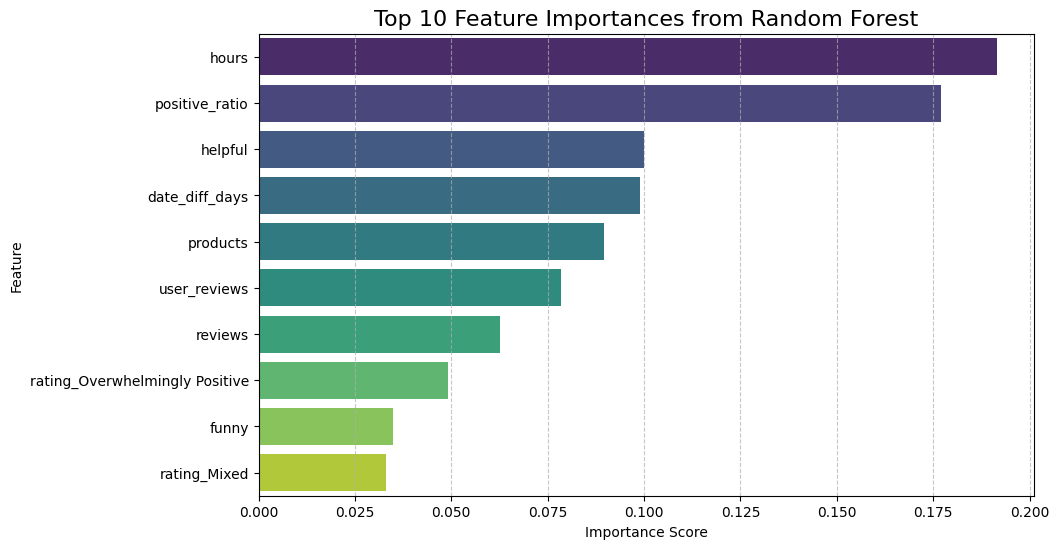

In [ ]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(X_train)
x_test_std = scaler.transform(X_test)

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50],
    'max_depth': [10, 20, 30],
    'min_samples_split': [10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_rf.fit(x_train_std, y_train)

best_rf = grid_search_rf.best_estimator_

importances = best_rf.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-46-55e3d5b336c1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=least_important_features, palette='coolwarm')


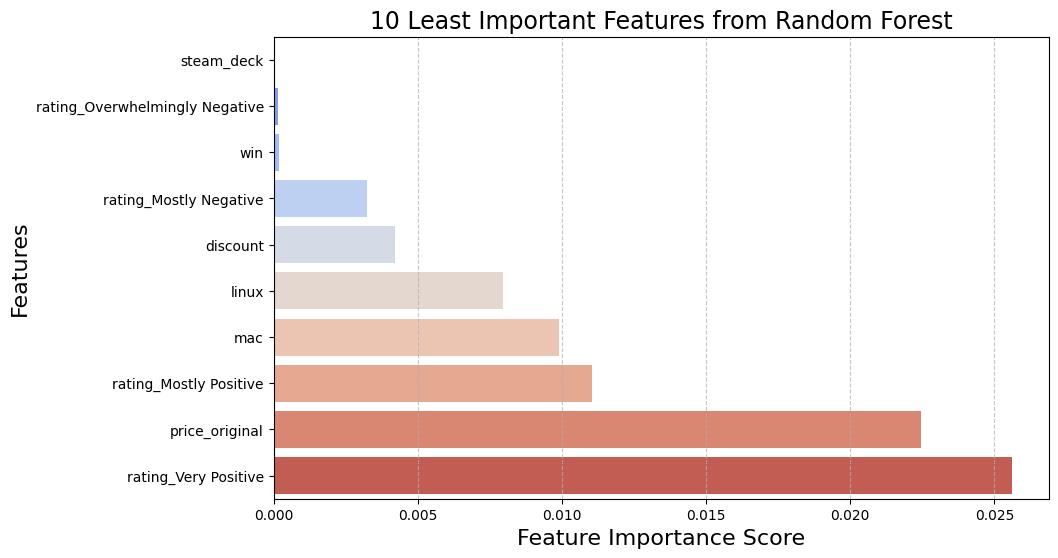

In [46]:
importances = best_rf.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
# Sort by ascending importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Take the bottom 10
least_important_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=least_important_features, palette='coolwarm')
plt.title('10 Least Important Features from Random Forest', fontsize=17)
plt.xlabel('Feature Importance Score', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-47-b78f58a2ef68>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top10_gb_features, palette='viridis')


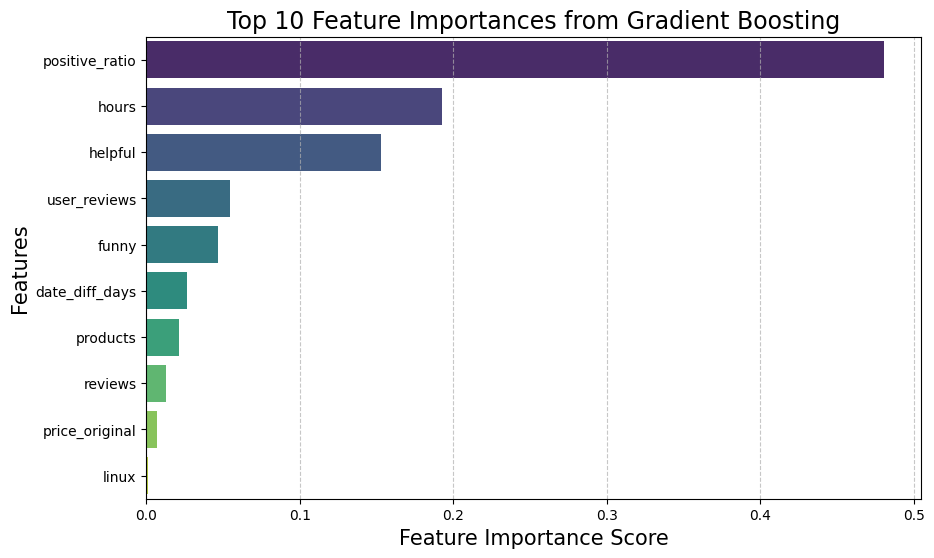

In [47]:
# Feature importance from Gradient Boosting
gb_importances = best_model.feature_importances_

# Create a DataFrame
gb_feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_importances
})

# Sort by descending importance
gb_feature_importance_df = gb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Take the Top 10
top10_gb_features = gb_feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_gb_features, palette='viridis')
plt.title('Top 10 Feature Importances from Gradient Boosting', fontsize=17)
plt.xlabel('Feature Importance Score', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-48-af0891fb989a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=least10_gb_features, palette='coolwarm')


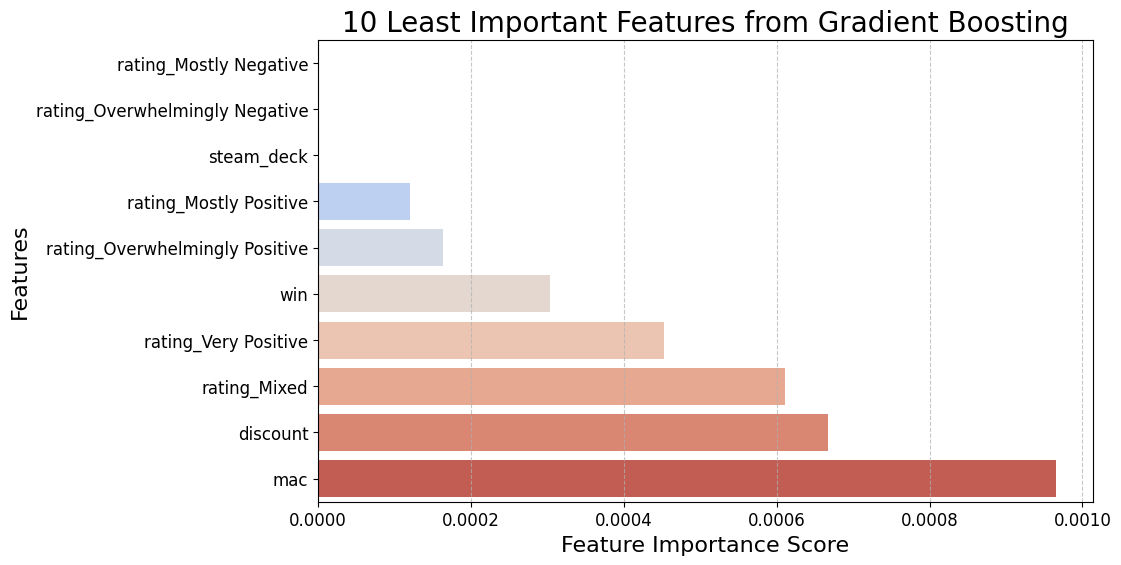

In [48]:
# Sort by ascending importance
least10_gb_features = gb_feature_importance_df.sort_values(by='Importance', ascending=True).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=least10_gb_features, palette='coolwarm')
plt.title('10 Least Important Features from Gradient Boosting', fontsize=20)
plt.xlabel('Feature Importance Score', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()